# Estimate sample phases using ML
- itk user-selection
- voxel clustering
- super voxel

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import itk
import itkwidgets
from itkwidgets import view, compare

In [3]:
print(itkwidgets.__version__)

0.30.1


In [4]:
from glob import glob
slices = glob('../images/concrete/*.tiff')
slices.sort()
concrete = itk.imread(slices)
print(itk.size(concrete))
print(itk.spacing(concrete))

itkSize3 ([2560, 2560, 31])
itkVectorD3 ([1, 1, 1])


In [5]:
new_spacing = [1, 1, 1] #change slice thickness to 1,1,2 for a different view
concrete.SetSpacing(new_spacing)

## ITK user selection

In [6]:
myViewer = view(concrete, mode='z') #slicing over z
myViewer

Viewer(geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itk.itkImagePython.itkIm…

In [7]:
#These are the coordinates of your crop
myViewer.roi_region()
#[789, 1102, 0], [700, 681, 31]

itkImageRegion3([0, 0, 0], [2560, 2560, 31])

In [10]:
myViewer.roi_slice()

(slice(0, 32, None), slice(0, 2561, None), slice(0, 2561, None))

In [29]:
# User-selection is input for slicing np array
np_concrete = itk.array_from_image(concrete) 
roi = (slice(0, 31, None), slice(700, 900, None), slice(700, 900, None))
np_coreSample = np_concrete[roi]
#view(np_coreSample, annotations=False, ui_collapsed=True)

In [55]:
#alternatively, just read my ROI
np_coreSample = itk.imread('../images/roiFiltered.tiff')

In [56]:
np_coreSample.shape

(31, 546, 658)

In [57]:
coreSample = itk.GetImageFromArray(np.ascontiguousarray(np_coreSample))
coreSample = itk.median_image_filter(coreSample)
view(coreSample)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [58]:
#itk.imwrite(coreSample,'../images/roiFiltered.tiff')


## Prepare data for voxel clustering
- recreating volume with the least possible intensity values

In [59]:
from skimage import img_as_ubyte
np_coreSample = itk.array_from_image(coreSample)
#np_coreSample = np_coreSample[:,::2,::2] #downsample for quick testing
np_coreSample = (np_coreSample - np.min(np_coreSample)) / np.max(np_coreSample-np.min(np_coreSample))
#np_coreSample = img_as_ubyte(np_coreSample)

In [60]:
#plt.imshow((np_coreSample[1,:,:]))
view(255*np_coreSample)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [61]:
x, y, z = np_coreSample.shape
np_coreSampFlat = np_coreSample.reshape((-1,1))
np_coreSampFlat.shape

(11137308, 1)

In [62]:
len(np.unique(np_coreSampFlat))

2913112

## Clustering using K-means

In [63]:
from sklearn import cluster
import time
start_time = time.time()

numberOfClusters = 3
kmeans_cluster = cluster.KMeans(n_clusters=numberOfClusters)
kmeans_cluster.fit(np_coreSampFlat)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

duration = time.time() - start_time
print(f"Duration {duration} seconds")

Duration 37.25493288040161 seconds


In [64]:
img_labels = cluster_centers[cluster_labels].reshape(x, y, z)

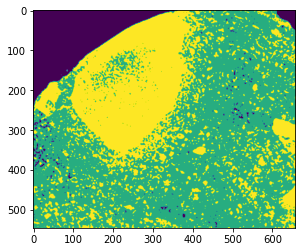

In [65]:
plt.imshow(img_labels[15,:,:]) #cmp with np_coreSample

In [66]:
itk.imwrite(itk.GetImageFromArray(img_labels),'../images/roiLabels.tiff')

In [67]:
#TODO: using img_as_ubyte here is a hack... 
#img_labels = img_as_ubyte( (img_labels-np.min(img_labels))/np.max(img_labels-np.min(img_labels)) )
view(itk.GetImageFromArray(img_labels))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [68]:
view(img_labels,annotations=False, ui_collapsed=True,mode='z')

Viewer(annotations=False, geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itk.i…

In [69]:
names = [(0, 'Background'), (1, 'Matrix'), (2, 'Aggregates')]
viewer = view(coreSample,
label_map=img_labels,
label_map_names=names,
rotate=False,
gradient_opacity=0.5,
slicing_planes=True)
viewer

Viewer(geometries=[], gradient_opacity=0.5, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; prox…

In [70]:
label_count = len(np.unique((img_labels)))
label_weights = np.ones((label_count,), dtype=np.float32)
label_weights[1] = 0.1
label_weights[2] = 0.2
viewer.label_map_weights = label_weights
#viewer

## SuperPixel through SLIC

In [71]:
print("Image dim: ",np_coreSample.shape)
from skimage import color
from skimage.segmentation import slic
aSlice = np_coreSample[15,:,:]
w,h = aSlice.shape
nSegms = np.ceil(np.sqrt(w*h)) #The (approximate) number of labels in the segmented output image.
print("Number of segments:",nSegms)


Image dim:  (31, 546, 658)
Number of segments: 600.0


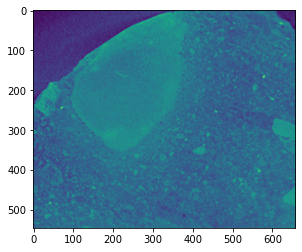

In [72]:
plt.imshow(aSlice.astype(np.double))

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


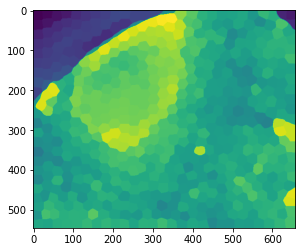

In [73]:

segments = slic(aSlice.astype(np.double), n_segments=nSegms, 
                compactness=0.1, enforce_connectivity=False, 
                sigma=5, max_iter=200, multichannel=False) #higher compact = more weight space, more square
output = color.label2rgb(segments, aSlice, kind='avg')
plt.imshow(output)

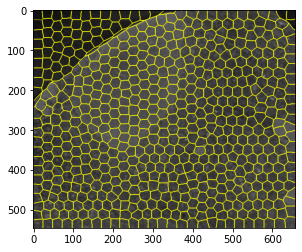

In [75]:
from skimage.segmentation import mark_boundaries
plt.imshow(mark_boundaries(aSlice, segments))

In [76]:
#Apply to volume
x,y,z=np_coreSample.shape
nSegms = z*nSegms
print("Number of segments:",nSegms)

Number of segments: 394800.0


In [ ]:

segments = slic(np_coreSample.astype(np.double), n_segments=nSegms, 
                compactness=0.1, enforce_connectivity=False, sigma=5, 
                max_iter=200, multichannel=False) #higher compact = more weight space, more square

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


In [ ]:
output = color.label2rgb(segments, np_coreSample, kind='avg')

In [ ]:
view(output)